## Data Pre-Process

### Import Data and Create Column Names
1. Import data as a table
2. Add column names into the table

In [2]:
T = readtable('C:\Users\jerem\Documents\Python Scripts\Scania\clean_data.csv');

T.Properties.VariableNames = {'KVSV1', 'OTGT1', 'OTGT6', 'OTSV1', 'QV11', 'TV11', 'TV12', 'TV_Cmd'};

### Create mini batch
Input Command: TV_Cmd    <br>
Input 3-way valve: OTSV1 <br>
Output Temp: TV12

In [3]:
mini_batch_train = T(1:5000:end, :);
mini_batch_test  = T(2:5000:end, :);

u_train = table2array(mini_batch_train(:, 4));   % OTSV1
y_train = table2array(mini_batch_train(:, 7));   % TV12

u_test = table2array(mini_batch_test(:, 4));   % OTSV1
y_test = table2array(mini_batch_test(:, 7));   % TV12

### Create iddata object for Training and Testing
data = iddata(*input*, *ouput*, *sampling time*)

In [10]:
Ts = 0.002;   % 2ms

%% Training Data
data_train = iddata(u_train, y_train, Ts);

data_train.Name = 'mini_batch_train';
data_train.TimeUnit = 'seconds';

data_train.InputName = 'OTSV1';   data_train.InputUnit = 'Percentage';
data_train.OutputName = 'TV12';   data_train.OutputUnit = 'Celsius';

%% Testing Data
data_test = iddata(u_test, y_test, Ts);

data_test.Name = 'mini_batch_test';
data_test.TimeUnit = 'seconds';

data_test.InputName = 'OTSV1';   data_test.InputUnit = 'Percentage';
data_test.OutputName = 'TV12';   data_test.OutputUnit = 'Celsius';

%% Print Data
get(data_train)


ans = 

  struct with fields:

              Domain: 'Time'
                Name: 'mini_batch_train'
          OutputData: [323x1 double]
                   y: 'Same as OutputData'
          OutputName: {'TV12'}
          OutputUnit: {'Celsius'}
           InputData: [323x1 double]
                   u: 'Same as InputData'
           InputName: {'OTSV1'}
           InputUnit: {'Percentage'}
              Period: Inf
         InterSample: 'zoh'
                  Ts: 0.0020
              Tstart: []
    SamplingInstants: [323x0 double]
            TimeUnit: 'seconds'
      ExperimentName: 'Exp1'
               Notes: {}
            UserData: []




### Check Nonlinearity

In [6]:
advice(data_train, 'nonlinearity')

There is an indication of nonlinearity in the data.
A nonlinear ARX model of order [4 4 1] and treepartition nonlinearity estimator 
performs better prediction of output than the corresponding ARX model of the 
same order. Consider using nonlinear models, such as IDNLARX, or IDNLHW. You 
may also use the "isnlarx" command to test for nonlinearity with more options.




### Plot Input-Output

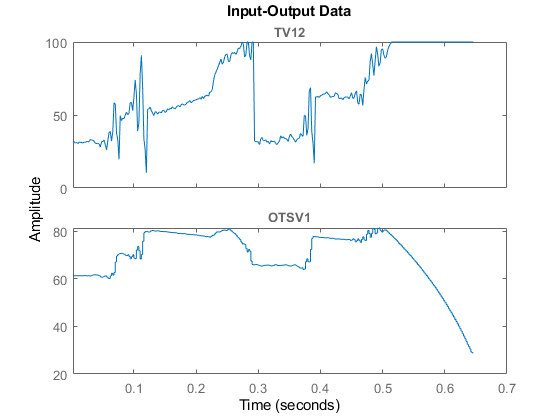

In [9]:
plot(data_train)

The last part of the data seems werid because the heating valve is still heating up. So remove the part after 0.5 sec

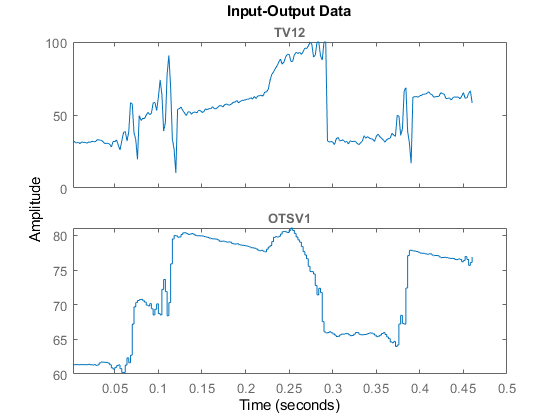

In [12]:
data_train = data_train(1:230);
plot(data_train)

## System Identification: Transfer Function Model

sysTF = tfest(*data*, *Num of Poles*, *Num of Zeros*)

### Set estimation options

In [47]:
opt = tfestOptions;
opt.InitializeMethod = 'all';
opt.SearchOptions.MaxIterations = 60; 
opt.Display = 'on';

### Estimate TF model

In [24]:
np = 4;          % Num of pole
nz = 3;          % Num of zero
iodelay = 20.0;   % In/Out delay

sysTF = tfest(data_train, np, nz, opt)


sysTF =
 
  From input "OTSV1" to output "TV12":
     178.9 s^3 + 1978 s^2 + 1.521e05 s + 9.647e04
  --------------------------------------------------
  s^4 + 34.85 s^3 + 2064 s^2 + 2.959e04 s + 1.218e05
 
Continuous-time identified transfer function.

Parameterization:
   Number of poles: 4   Number of zeros: 3
   Number of free coefficients: 8
   Use "tfdata", "getpvec", "getcov" for parameters and their uncertainties.

Status:                                                      
Estimated using TFEST on time domain data "mini_batch_train".
Fit to estimation data: 52.77%                               
FPE: 102.6, MSE: 92.45                                       



### Advice on the estimated model

In [18]:
advice(sysTF, data_test)

                                                                                                                                                                                                                                                                                                                              
The model may be improved if more iterations in the search are used. Try, for 
example:
   Options = sysTF.Report.OptionsUsed;
   Options.SearchOptions.MaxIterations = 60; 
   sysTF = pem(sysTF, mini_batch_train, Options)                                                                                                 
                                                                                                                                                                                                                                                                                                                              
There is a strong indication that the dynam

### Error Analysis Transfer Function Model

### Normalised Root Mean Square Error (NRMSE)
$RMSE = \sqrt{\frac{\Sigma_{i=1}^{N}(y_{i}-\hat{y_{i}})^2}{N}}$ $\qquad$  $NRMSE = \frac{RMSE}{\bar{y}}$

In NRMSE, we try to find the goodness of fit between observed and estimated outputs of the estimated model. There are two ways to do a NRMSE analysis. ([link](https://se.mathworks.com/help/ident/ref/goodnessoffit.html#mw_3c7ec9a5-4198-4129-9f89-588593935a1c)) <br>
1. goodnessofFit() <br>
> returns the goodness of fit between the test data x and the reference data xref using the cost function cost_func. fit is a quantitative representation of the closeness of x to xref
2. compare() <br>
> compare uses the NRMSE cost function, and expresses the fit percentage using the one's complement of the error norm. <br>
> The fit relationship between compare and goodnessOfFit is therefore fit compare =(1−fitgof)∗100.

--> A compare result of 100% is equivalent to a goodnessOfFit result of 0.

#### Goodness of Fit

In [62]:
% generate reference output
y_tf_ref = data_train.y;

% generate estimated output
y_tf_est = sim(sysTF, data_train(:, [], :));

% select cost function
cost_func = 'NRMSE';

% Goodness of Fit
fit = goodnessOfFit(y_tf_est.y, y_tf_ref, cost_func)


fit =

    8.1764




#### Compare

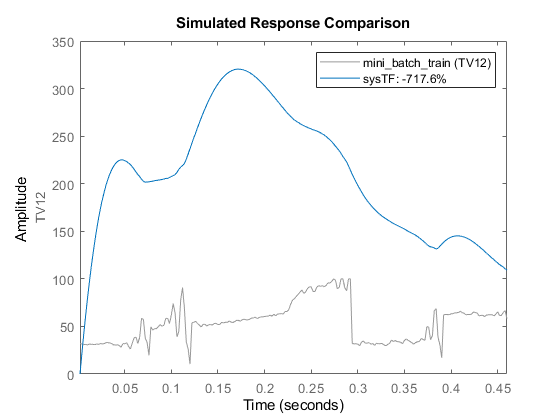

In [63]:
% Specify an initial condition of zero to match the initial condition that goodnessOfFit assumes
opt = compareOptions('InitialCondition','z');   % 'z' : zero initial conditions
compare(data_train, sysTF, opt);

### Residual Analysis
**Auto-correlation** <br>
$r_k = \frac{\sum\limits_{i=1}^{N-k} (Y_i-\bar{Y})(Y_{i+k}-\bar{Y})}{\sum\limits_{i=1}^{N}(Y_i-\bar{Y})^2}$
> $r_k$     = Autocorrelation at lag k   <br>
> $Y_i$     = Data output at timestamp i <br>
> $\bar{Y}$ = Output sample mean         <br>
> $N$ = Total number of data points      <br> <br>

**Cross-correlation** <br>
$r_k = \frac{\sum\limits_{i=1}^{N-k} (X_i-\bar{X})(Y_{i+k}-\bar{Y})}{\sqrt{\sum\limits_{i=1}^{N}(X_i-\bar{X})^2 \sum\limits_{i=1}^{N}(Y_i-\bar{Y})^2}}$
> $r_k$ = Cross-correlation at lag k <br>
> $X_i$ = X variable value at timestamp i <br>
> $Y_i$ = Y variable value at timestamp i <br>
> $\bar{X}$ = X variable sample mean  <br>
> $\bar{Y}$ = Y variable sample mean  <br>
> $N$ = total number of data points

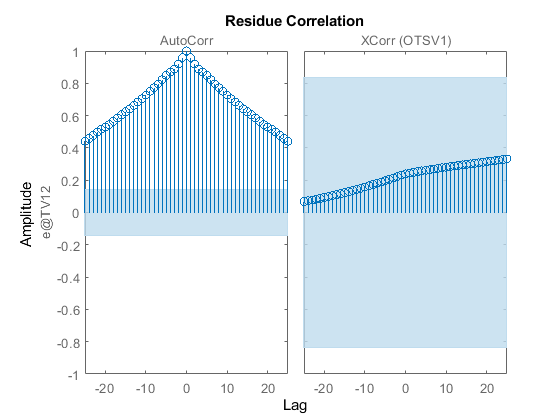

In [64]:
resid(data_test,sysTF)

### Final Prediction Error
$FPE = \varepsilon_{e} (\frac{N+d}{N-d}), \qquad \varepsilon_{e} = \frac{1}{N} \Sigma_{i=1}^{N}(y_{i}-\hat{y_{i}})^2 = \frac{1}{N}\Sigma_{i=1}^{N}e_{i}^2$
> $N$ = Number of observations <br>
> $d$ = Number of estimated parameters  <br>
> $y_{i}$ = True output value  <br>
> $\hat{y_{i}}$ = Predicted output value

The Final Prediction Error analysis is already done in tfest, ssest, etc.

## System Identification: State Space Model

sysSS = ssest(*data*, *Num of Poles*, *Num of Zeros*)

### Set estimation options

In [48]:
opt = ssestOptions;
opt.InitializeMethod = 'auto';
opt.Focus = 'prediction';
opt.SearchOptions.MaxIterations = 50; 
opt.Display = 'on';

### Estimate SS model

In [52]:
nx = 2
sysSS = ssest(data_train, nx, opt)


nx =

     2


sysSS =
  Continuous-time identified state-space model:
      dx/dt = A x(t) + B u(t) + K e(t)
       y(t) = C x(t) + D u(t) + e(t)
 
  A = 
           x1      x2
   x1  -91.96   165.6
   x2  -177.4  -468.1
 
  B = 
        OTSV1
   x1  -9.804
   x2   30.11
 
  C = 
             x1      x2
   TV12   263.8  -13.82
 
  D = 
         OTSV1
   TV12      0
 
  K = 
        TV12
   x1  1.049
   x2   3.21
 
Parameterization:
   FREE form (all coefficients in A, B, C free).
   Feedthrough: none
   Disturbance component: estimate
   Number of free coefficients: 10
   Use "idssdata", "getpvec", "getcov" for parameters and their uncertainties.

Status:                                                      
Estimated using SSEST on time domain data "mini_batch_train".
Fit to estimation data: 58.01% (prediction focus)            
FPE: 78.33, MSE: 73.07                                       



### Advice on the estimated model

In [50]:
advice(sysSS, data_test)

                                                                                                                                                                                                                                           
The model may be improved if more iterations in the search are used. Try, for 
example:
   Options = sysSS.Report.OptionsUsed;
   Options.SearchOptions.MaxIterations = 60; 
   sysSS = pem(sysSS, mini_batch_train, Options)              
                                                                                                                                                                                                                                           
There is a very strong indication that the dynamics of the model is not 
adequately described.                                                                                                                                             
                                                        

### Error Analysis State Space Model

### Normalised Root Mean Square Error (NRMSE)
$RMSE = \sqrt{\frac{\Sigma_{i=1}^{N}(y_{i}-\hat{y_{i}})^2}{N}}$ $\qquad$  $NRMSE = \frac{RMSE}{\bar{y}}$

In NRMSE, we try to find the goodness of fit between observed and estimated outputs of the estimated model. There are two ways to do a NRMSE analysis. ([link](https://se.mathworks.com/help/ident/ref/goodnessoffit.html#mw_3c7ec9a5-4198-4129-9f89-588593935a1c)) <br>
1. goodnessofFit() <br>
> returns the goodness of fit between the test data x and the reference data xref using the cost function cost_func. fit is a quantitative representation of the closeness of x to xref
2. compare() <br>
> compare uses the NRMSE cost function, and expresses the fit percentage using the one's complement of the error norm. <br>
> The fit relationship between compare and goodnessOfFit is therefore fit compare =(1−fitgof)∗100.

--> A compare result of 100% is equivalent to a goodnessOfFit result of 0.

#### Goodness of Fit

In [57]:
% generate reference output
y_ss_ref = data_train.y;

% generate estimated output
y_ss_est = sim(sysSS, data_train(:, [], :));

% select cost function
cost_func = 'NRMSE';

% Goodness of Fit
fit = goodnessOfFit(y_ss_est.y, y_ss_ref, cost_func)


fit =

    1.9173




#### Compare

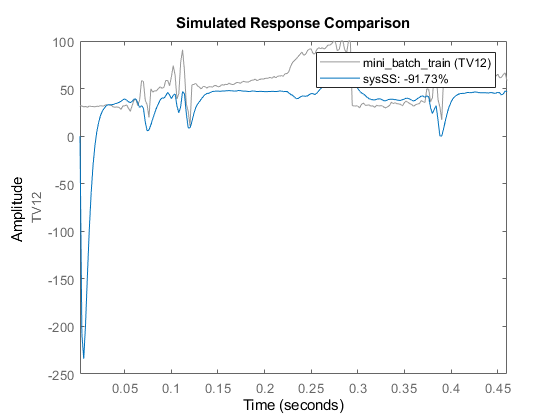

In [59]:
% Specify an initial condition of zero to match the initial condition that goodnessOfFit assumes
opt = compareOptions('InitialCondition','z');   % 'z' : zero initial conditions
compare(data_train, sysSS, opt);

### Residual Analysis
**Auto-correlation** <br>
$r_k = \frac{\sum\limits_{i=1}^{N-k} (Y_i-\bar{Y})(Y_{i+k}-\bar{Y})}{\sum\limits_{i=1}^{N}(Y_i-\bar{Y})^2}$
> $r_k$     = Autocorrelation at lag k   <br>
> $Y_i$     = Data output at timestamp i <br>
> $\bar{Y}$ = Output sample mean         <br>
> $N$ = Total number of data points      <br> <br>

**Cross-correlation** <br>
$r_k = \frac{\sum\limits_{i=1}^{N-k} (X_i-\bar{X})(Y_{i+k}-\bar{Y})}{\sqrt{\sum\limits_{i=1}^{N}(X_i-\bar{X})^2 \sum\limits_{i=1}^{N}(Y_i-\bar{Y})^2}}$
> $r_k$ = Cross-correlation at lag k <br>
> $X_i$ = X variable value at timestamp i <br>
> $Y_i$ = Y variable value at timestamp i <br>
> $\bar{X}$ = X variable sample mean  <br>
> $\bar{Y}$ = Y variable sample mean  <br>
> $N$ = total number of data points

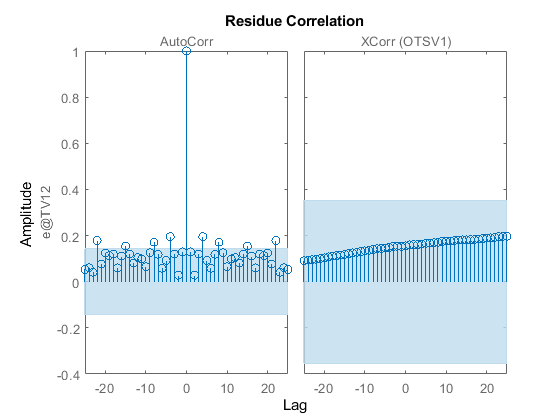

In [35]:
resid(data_test,sysSS)

### Final Prediction Error
$FPE = \varepsilon_{e} (\frac{N+d}{N-d}), \qquad \varepsilon_{e} = \frac{1}{N} \Sigma_{i=1}^{N}(y_{i}-\hat{y_{i}})^2 = \frac{1}{N}\Sigma_{i=1}^{N}e_{i}^2$
> $N$ = Number of observations <br>
> $d$ = Number of estimated parameters  <br>
> $y_{i}$ = True output value  <br>
> $\hat{y_{i}}$ = Predicted output value

The Final Prediction Error analysis is already done in tfest, ssest, etc.

## System Identification: ARX Model

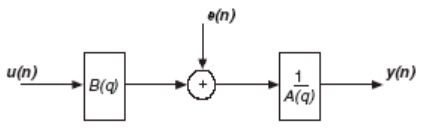 <br>
sysARX = arx(data, [na, nb, nk]) ([link](https://se.mathworks.com/help/ident/ref/arx.html))
> na: Order of A(q)
> nb: Order of B(q)+1
> nk: Input-Output delay

### Set estimation options

In [78]:
opt = arxOptions;
opt.Focus = 'prediction';

### Coarse search model order

We cam use **[arxstruc()](https://se.mathworks.com/help/ident/ref/arxstruc.html)** and **[selstruc()](https://se.mathworks.com/help/ident/ref/selstruc.html)** to find a suggested ARX model structure
* arxstruc(estimation_data, validation_data, range )
> range = [na nb nk] <br>
> is the selected range of na, nb, nk <br>
> Ex: V = arxstruc(ze, zv, struc( 1:10, 1:10, 1:5 ));
* selstruc(arxstruc, 'criterion' )
> Ex: Order = selstruc(V,'aic'); <br>
> Find the best ARX model order based on Arkaike's Information Criterion 


In [79]:
range = struc(1:10, 1:10, 1:5);
V = arxstruc(data_train, data_test, range);
Order = selstruc(V, 'aic')


Order =

     2     5     1




### Estimate ARX model

In [80]:
sysARX = arx(data_train, [2 5 1])


sysARX =
Discrete-time ARX model: A(z)y(t) = B(z)u(t) + e(t)                      
  A(z) = 1 - 0.6428 z^-1 - 0.2878 z^-2                                   
                                                                         
  B(z) = -5.551 z^-1 + 6.502 z^-2 + 0.7219 z^-3 + 1.402 z^-4 - 3.021 z^-5
                                                                         
Sample time: 0.002 seconds
  
Parameterization:
   Polynomial orders:   na=2   nb=5   nk=1
   Number of free coefficients: 7
   Use "polydata", "getpvec", "getcov" for parameters and their uncertainties.

Status:                                                    
Estimated using ARX on time domain data "mini_batch_train".
Fit to estimation data: 69.86% (prediction focus)          
FPE: 41.78, MSE: 37.64                                     



### Advice on the estimated model

In [81]:
advice(sysTF, data_test)

                                                                                                                                                                                                                                                                                                                              
The model may be improved if more iterations in the search are used. Try, for 
example:
   Options = sysTF.Report.OptionsUsed;
   Options.SearchOptions.MaxIterations = 70; 
   sysTF = pem(sysTF, mini_batch_train, Options)                                                                                                 
                                                                                                                                                                                                                                                                                                                              
There is a strong indication that the dynam

### Normalised Root Mean Square Error (NRMSE)
$RMSE = \sqrt{\frac{\Sigma_{i=1}^{N}(y_{i}-\hat{y_{i}})^2}{N}}$ $\qquad$  $NRMSE = \frac{RMSE}{\bar{y}}$

In NRMSE, we try to find the goodness of fit between observed and estimated outputs of the estimated model. There are two ways to do a NRMSE analysis. ([link](https://se.mathworks.com/help/ident/ref/goodnessoffit.html#mw_3c7ec9a5-4198-4129-9f89-588593935a1c)) <br>
1. goodnessofFit() <br>
> returns the goodness of fit between the test data x and the reference data xref using the cost function cost_func. fit is a quantitative representation of the closeness of x to xref
2. compare() <br>
> compare uses the NRMSE cost function, and expresses the fit percentage using the one's complement of the error norm. <br>
> The fit relationship between compare and goodnessOfFit is therefore fit compare =(1−fitgof)∗100.

--> A compare result of 100% is equivalent to a goodnessOfFit result of 0.

### Error Analysis ARX Model

#### Goodness of Fit

In [82]:
% generate reference output
y_arx_ref = data_train.y;

% generate estimated output
y_arx_est = sim(sysARX, data_train(:, [], :));

% select cost function
cost_func = 'NRMSE';

% Goodness of Fit
fit = goodnessOfFit(y_arx_est.y, y_arx_ref, cost_func)


fit =

    1.6066




#### Compare

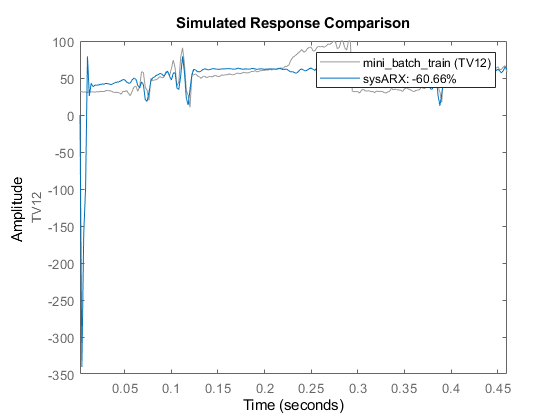

In [83]:
% Specify an initial condition of zero to match the initial condition that goodnessOfFit assumes
opt = compareOptions('InitialCondition','z');   % 'z' : zero initial conditions
compare(data_train, sysARX, opt);

### Residual Analysis
**Auto-correlation** <br>
$r_k = \frac{\sum\limits_{i=1}^{N-k} (Y_i-\bar{Y})(Y_{i+k}-\bar{Y})}{\sum\limits_{i=1}^{N}(Y_i-\bar{Y})^2}$
> $r_k$     = Autocorrelation at lag k   <br>
> $Y_i$     = Data output at timestamp i <br>
> $\bar{Y}$ = Output sample mean         <br>
> $N$ = Total number of data points      <br> <br>

**Cross-correlation** <br>
$r_k = \frac{\sum\limits_{i=1}^{N-k} (X_i-\bar{X})(Y_{i+k}-\bar{Y})}{\sqrt{\sum\limits_{i=1}^{N}(X_i-\bar{X})^2 \sum\limits_{i=1}^{N}(Y_i-\bar{Y})^2}}$
> $r_k$ = Cross-correlation at lag k <br>
> $X_i$ = X variable value at timestamp i <br>
> $Y_i$ = Y variable value at timestamp i <br>
> $\bar{X}$ = X variable sample mean  <br>
> $\bar{Y}$ = Y variable sample mean  <br>
> $N$ = total number of data points

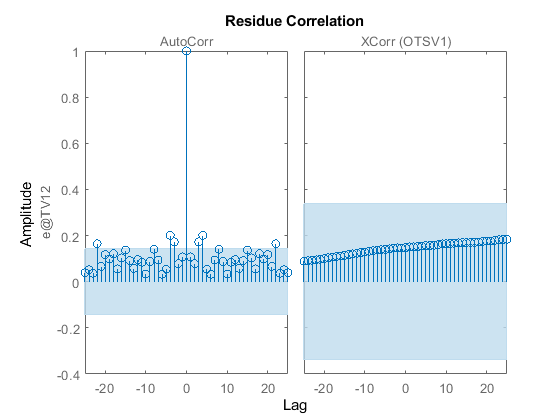

In [84]:
resid(data_test,sysARX)

### Final Prediction Error
$FPE = \varepsilon_{e} (\frac{N+d}{N-d}), \qquad \varepsilon_{e} = \frac{1}{N} \Sigma_{i=1}^{N}(y_{i}-\hat{y_{i}})^2 = \frac{1}{N}\Sigma_{i=1}^{N}e_{i}^2$
> $N$ = Number of observations <br>
> $d$ = Number of estimated parameters  <br>
> $y_{i}$ = True output value  <br>
> $\hat{y_{i}}$ = Predicted output value

## System Identification: ARMAX Model

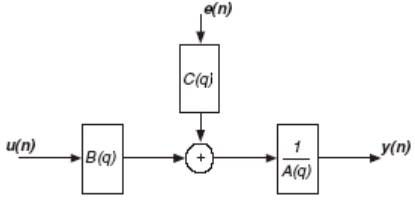 <br>
sysARMAX = armax(data, [na nb nc nk]) ([link](https://se.mathworks.com/help/ident/ref/armax.html))
> na: Order of A(q)
> nb: Order of B(q)+1
> nc: Order of C(q)
> nk: Input-Output delay

### Set estimation options

In [85]:
opt = armaxOptions;
opt.Focus = 'prediction';
opt.SearchOptions.MaxIterations = 100;
opt.SearchOptions.Tolerance = 1e-5;

### Estimate ARMAX model

In [88]:
na = 9;
nb = 9;
nc = 9;
nk = 0;
sysARMAX = armax(data_train, [na nb nc nk], opt)


sysARMAX =
Discrete-time ARMAX model: A(z)y(t) = B(z)u(t) + C(z)e(t)                                                                 
                                                                                                                          
  A(z) = 1 - 0.3319 z^-1 - 1.264 z^-2 - 0.3016 z^-3 + 0.7046 z^-4 + 0.6124 z^-5 - 0.4878 z^-6 - 0.1397 z^-7 + 0.342 z^-8  
                                                                                                            - 0.108 z^-9  
                                                                                                                          
                                                                                                                          
B(z) = -1.609 - 3.849 z^-1 + 4.292 z^-2 + 8.622 z^-3 - 0.09634 z^-4 - 8.016 z^-5 - 5.968 z^-6 + 6.822 z^-7 - 0.1771 z^-8  
                                                                                                                          
    

### Advice on the estimated model

In [72]:
advice(sysTF, data_test)

                                                                                                                                                                                                                                                                                                                              
The model may be improved if more iterations in the search are used. Try, for 
example:
   Options = sysTF.Report.OptionsUsed;
   Options.SearchOptions.MaxIterations = 70; 
   sysTF = pem(sysTF, mini_batch_train, Options)                                                                                                 
                                                                                                                                                                                                                                                                                                                              
There is a strong indication that the dynam

### Normalised Root Mean Square Error (NRMSE)
$RMSE = \sqrt{\frac{\Sigma_{i=1}^{N}(y_{i}-\hat{y_{i}})^2}{N}}$ $\qquad$  $NRMSE = \frac{RMSE}{\bar{y}}$

In NRMSE, we try to find the goodness of fit between observed and estimated outputs of the estimated model. There are two ways to do a NRMSE analysis. ([link](https://se.mathworks.com/help/ident/ref/goodnessoffit.html#mw_3c7ec9a5-4198-4129-9f89-588593935a1c)) <br>
1. goodnessofFit() <br>
> returns the goodness of fit between the test data x and the reference data xref using the cost function cost_func. fit is a quantitative representation of the closeness of x to xref
2. compare() <br>
> compare uses the NRMSE cost function, and expresses the fit percentage using the one's complement of the error norm. <br>
> The fit relationship between compare and goodnessOfFit is therefore fit compare =(1−fitgof)∗100.

--> A compare result of 100% is equivalent to a goodnessOfFit result of 0.

### Error Analysis ARX Model

#### Goodness of Fit

In [90]:
% generate reference output
y_armax_ref = data_train.y;

% generate estimated output
y_armax_est = sim(sysARMAX, data_train(:, [], :));

% select cost function
cost_func = 'NRMSE';

% Goodness of Fit
fit = goodnessOfFit(y_armax_est.y, y_armax_ref, cost_func)


fit =

    2.4299




#### Compare

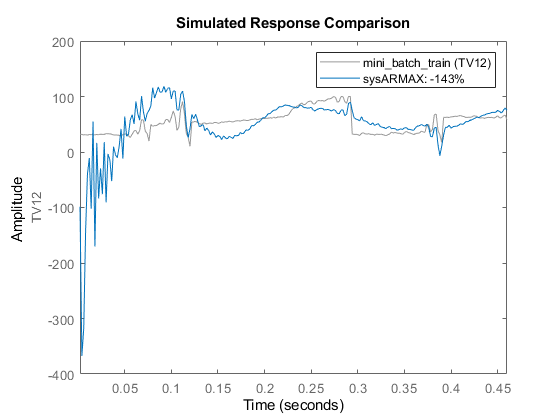

In [91]:
% Specify an initial condition of zero to match the initial condition that goodnessOfFit assumes
opt = compareOptions('InitialCondition','z');   % 'z' : zero initial conditions
compare(data_train, sysARMAX, opt);

### Residual Analysis
**Auto-correlation** <br>
$r_k = \frac{\sum\limits_{i=1}^{N-k} (Y_i-\bar{Y})(Y_{i+k}-\bar{Y})}{\sum\limits_{i=1}^{N}(Y_i-\bar{Y})^2}$
> $r_k$     = Autocorrelation at lag k   <br>
> $Y_i$     = Data output at timestamp i <br>
> $\bar{Y}$ = Output sample mean         <br>
> $N$ = Total number of data points      <br> <br>

**Cross-correlation** <br>
$r_k = \frac{\sum\limits_{i=1}^{N-k} (X_i-\bar{X})(Y_{i+k}-\bar{Y})}{\sqrt{\sum\limits_{i=1}^{N}(X_i-\bar{X})^2 \sum\limits_{i=1}^{N}(Y_i-\bar{Y})^2}}$
> $r_k$ = Cross-correlation at lag k <br>
> $X_i$ = X variable value at timestamp i <br>
> $Y_i$ = Y variable value at timestamp i <br>
> $\bar{X}$ = X variable sample mean  <br>
> $\bar{Y}$ = Y variable sample mean  <br>
> $N$ = total number of data points

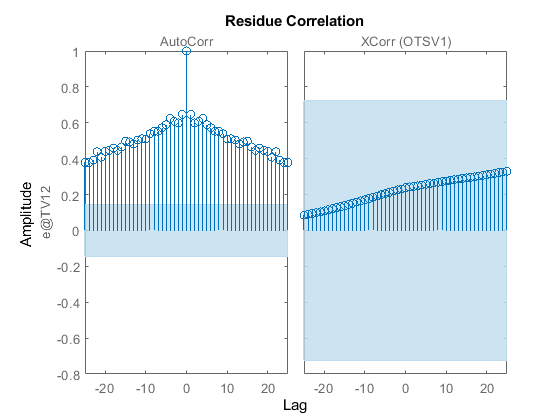

In [94]:
resid(data_test, sysARMAX)

### Final Prediction Error
$FPE = \varepsilon_{e} (\frac{N+d}{N-d}), \qquad \varepsilon_{e} = \frac{1}{N} \Sigma_{i=1}^{N}(y_{i}-\hat{y_{i}})^2 = \frac{1}{N}\Sigma_{i=1}^{N}e_{i}^2$
> $N$ = Number of observations <br>
> $d$ = Number of estimated parameters  <br>
> $y_{i}$ = True output value  <br>
> $\hat{y_{i}}$ = Predicted output value

## System Identification: BJ Model

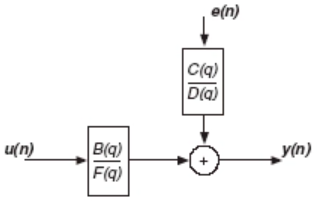 <br>
sysBJ = bj(data, [nb nc nd nf nk]) ([link](https://se.mathworks.com/help/ident/ref/bj.html))
> nb: Order of B(q)+1
> nc: Order of C(q)+1
> nd: Order of D(q)+1
> nf: Order of F(q)+1
> nk: Input-Output delay

### Set estimation options

In [68]:
opt = armaxOptions;
opt.Focus = 'prediction';
opt.SearchOptions.MaxIterations = 100;
opt.SearchOptions.Tolerance = 1e-5;

### Coarse search model order

We cam use **[arxstruc()](https://se.mathworks.com/help/ident/ref/arxstruc.html)** and **[selstruc()](https://se.mathworks.com/help/ident/ref/selstruc.html)** to find a suggested ARX model structure
* arxstruc(estimation_data, validation_data, range )
> range = [na nb nk] <br>
> is the selected range of na, nb, nk <br>
> Ex: V = arxstruc(ze, zv, struc( 1:10, 1:10, 1:5 ));
* selstruc(arxstruc, 'criterion' )
> Ex: Order = selstruc(V,'aic'); <br>
> Find the best ARX model order based on Arkaike's Information Criterion 


In [70]:
range = struc(1:10, 1:10, 1:5);
V = arxstruc(data_train, data_test, range);
Order = selstruc(V, 'aic')


Order =

     2     5     1




### Estimate ARX model

In [71]:
sysARX = arx(data_train, [2 5 1])


sysARX =
Discrete-time ARX model: A(z)y(t) = B(z)u(t) + e(t)                      
  A(z) = 1 - 0.6428 z^-1 - 0.2878 z^-2                                   
                                                                         
  B(z) = -5.551 z^-1 + 6.502 z^-2 + 0.7219 z^-3 + 1.402 z^-4 - 3.021 z^-5
                                                                         
Sample time: 0.002 seconds
  
Parameterization:
   Polynomial orders:   na=2   nb=5   nk=1
   Number of free coefficients: 7
   Use "polydata", "getpvec", "getcov" for parameters and their uncertainties.

Status:                                                    
Estimated using ARX on time domain data "mini_batch_train".
Fit to estimation data: 69.86% (prediction focus)          
FPE: 41.78, MSE: 37.64                                     



### Advice on the estimated model

In [72]:
advice(sysTF, data_test)

                                                                                                                                                                                                                                                                                                                              
The model may be improved if more iterations in the search are used. Try, for 
example:
   Options = sysTF.Report.OptionsUsed;
   Options.SearchOptions.MaxIterations = 70; 
   sysTF = pem(sysTF, mini_batch_train, Options)                                                                                                 
                                                                                                                                                                                                                                                                                                                              
There is a strong indication that the dynam

### Normalised Root Mean Square Error (NRMSE)
$RMSE = \sqrt{\frac{\Sigma_{i=1}^{N}(y_{i}-\hat{y_{i}})^2}{N}}$ $\qquad$  $NRMSE = \frac{RMSE}{\bar{y}}$

In NRMSE, we try to find the goodness of fit between observed and estimated outputs of the estimated model. There are two ways to do a NRMSE analysis. ([link](https://se.mathworks.com/help/ident/ref/goodnessoffit.html#mw_3c7ec9a5-4198-4129-9f89-588593935a1c)) <br>
1. goodnessofFit() <br>
> returns the goodness of fit between the test data x and the reference data xref using the cost function cost_func. fit is a quantitative representation of the closeness of x to xref
2. compare() <br>
> compare uses the NRMSE cost function, and expresses the fit percentage using the one's complement of the error norm. <br>
> The fit relationship between compare and goodnessOfFit is therefore fit compare =(1−fitgof)∗100.

--> A compare result of 100% is equivalent to a goodnessOfFit result of 0.

### Error Analysis ARX Model

#### Goodness of Fit

In [73]:
% generate reference output
y_arx_ref = data_train.y;

% generate estimated output
y_arx_est = sim(sysARX, data_train(:, [], :));

% select cost function
cost_func = 'NRMSE';

% Goodness of Fit
fit = goodnessOfFit(y_arx_est.y, y_arx_ref, cost_func)


fit =

    1.6066




#### Compare

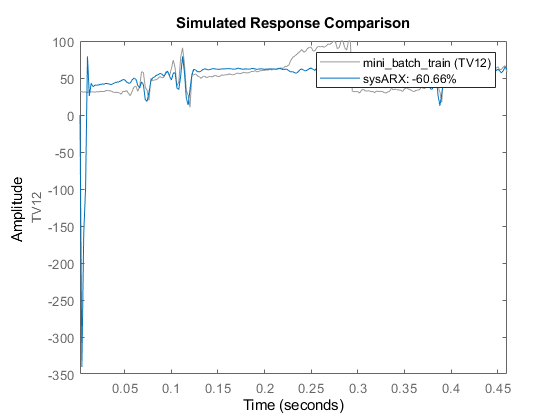

In [74]:
% Specify an initial condition of zero to match the initial condition that goodnessOfFit assumes
opt = compareOptions('InitialCondition','z');   % 'z' : zero initial conditions
compare(data_train, sysARX, opt);

### Residual Analysis
**Auto-correlation** <br>
$r_k = \frac{\sum\limits_{i=1}^{N-k} (Y_i-\bar{Y})(Y_{i+k}-\bar{Y})}{\sum\limits_{i=1}^{N}(Y_i-\bar{Y})^2}$
> $r_k$     = Autocorrelation at lag k   <br>
> $Y_i$     = Data output at timestamp i <br>
> $\bar{Y}$ = Output sample mean         <br>
> $N$ = Total number of data points      <br> <br>

**Cross-correlation** <br>
$r_k = \frac{\sum\limits_{i=1}^{N-k} (X_i-\bar{X})(Y_{i+k}-\bar{Y})}{\sqrt{\sum\limits_{i=1}^{N}(X_i-\bar{X})^2 \sum\limits_{i=1}^{N}(Y_i-\bar{Y})^2}}$
> $r_k$ = Cross-correlation at lag k <br>
> $X_i$ = X variable value at timestamp i <br>
> $Y_i$ = Y variable value at timestamp i <br>
> $\bar{X}$ = X variable sample mean  <br>
> $\bar{Y}$ = Y variable sample mean  <br>
> $N$ = total number of data points

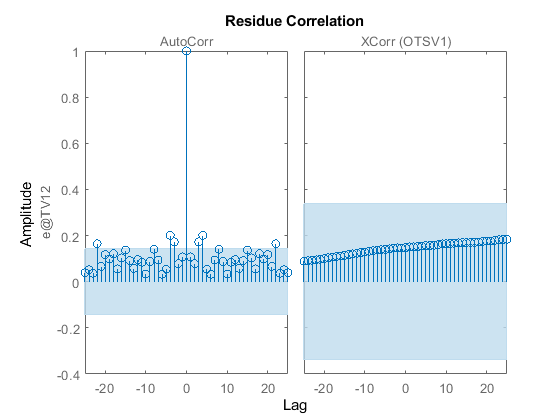

In [75]:
resid(data_test,sysARX)

### Final Prediction Error
$FPE = \varepsilon_{e} (\frac{N+d}{N-d}), \qquad \varepsilon_{e} = \frac{1}{N} \Sigma_{i=1}^{N}(y_{i}-\hat{y_{i}})^2 = \frac{1}{N}\Sigma_{i=1}^{N}e_{i}^2$
> $N$ = Number of observations <br>
> $d$ = Number of estimated parameters  <br>
> $y_{i}$ = True output value  <br>
> $\hat{y_{i}}$ = Predicted output value